In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from elon_musk_youtube_scraper import search_videos_advanced
from transformers import BertTokenizer, BertModel
import torch

In [73]:
# os.getcwd()
df = pd.read_csv('training_data_elon_musk.csv')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.head(5)

,videoid,url,is_interview?_(verified),title,channeltitle,publishedat,channelid,description,thumbnails,livebroadcastcontent,publishtime,duration,viewcount,likecount,dislikecount,commentcount,probabilities
0,iNa62HS--Zg,https://www.youtube.com/watch?v=iNa62HS--Zg,1,Everything Elon Musk Said At Tesla's Autonomy Day,Farzad,2024-04-22T13:00:41Z,UCgbyN_o-Guwpyqfuuz3pyIw,The Robots Are Coming https://www.farzadmesbah...,https://i.ytimg.com/vi/iNa62HS--Zg/default.jpg,none,NaN,30.27,65812,2956.00,NaN,542.00,NaN
1,FPpPTp7FIHY,https://www.youtube.com/watch?v=FPpPTp7FIHY,1,Elon Musk: “10X Every 6 Months”,Farzad,2024-04-08T20:23:13Z,UCgbyN_o-Guwpyqfuuz3pyIw,Check out the original spaces on X:\nPart 1 - ...,https://i.ytimg.com/vi/FPpPTp7FIHY/default.jpg,none,NaN,32.48,183533,5722.00,NaN,601.00,NaN
2,7DPR9rzVCzk,https://www.youtube.com/watch?v=7DPR9rzVCzk,1,Elon Musk delivers SpaceX update following Sta...,VideoFromSpace,2024-04-08T14:00:16Z,UCVTomc35agH1SM6kCKzwW_g,SpaceX's Elon Musk talks about progress being ...,https://i.ytimg.com/vi/7DPR9rzVCzk/default.jpg,none,NaN,39.82,113812,1918.00,NaN,462.00,NaN
3,826YO436Gqw,https://www.youtube.com/watch?v=826YO436Gqw,1,Elon Musk Delivers Bombshell SpaceX Presentati...,Matt Pocius on Tesla Stock & Money,2024-04-06T23:52:59Z,UCF1iS7Bp9_hsQphNF6o8qwQ,Elon Musk delivers NEW 2024 SpaceX presentatio...,https://i.ytimg.com/vi/826YO436Gqw/default.jpg,none,NaN,44.03,162997,2794.00,NaN,583.00,NaN
4,OffMED-KXIs,https://www.youtube.com/watch?v=OffMED-KXIs,1,Elon Musk SpaceX Presentation Leaves Audience ...,Farzad,2024-04-06T22:01:41Z,UCgbyN_o-Guwpyqfuuz3pyIw,Check out the full presentation here on X - ht...,https://i.ytimg.com/vi/OffMED-KXIs/default.jpg,none,NaN,27.55,1688199,31118.00,NaN,6518.00,NaN


In [74]:
# Create training data
X = df['description']
y = df['is_interview?_(verified)']

In [75]:
interview_counts = df['is_interview?_(verified)'].value_counts()
print(interview_counts)

is_interview?_(verified)
0    31
1    19
Name: count, dtype: int64


In [76]:
# Train Word2Vec model on the training data
word2vec_model = Word2Vec(X, vector_size=100, window=5, min_count=1, workers=4)

# Create input features using the Word2Vec model
def get_text_features(text):
    words = text.split()
    features = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if features:
        return np.mean(features, axis=0)
    else:
        return np.zeros(100)

In [77]:
X_numerical = [get_text_features(text) for text in X]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.20, random_state=42)

# Train logistic regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(y_pred_proba)

# Get predicted labels
y_pred = model.predict(X_test)

# Print classification report - for actual predicted labels
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix - for actual predicted labels
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Print ROC AUC curve - for probabilities
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

[0.56110995 0.43347464 0.43484447 0.63676554 0.65490643 0.63676554
 0.52209398 0.5788092  0.65490643 0.51517028]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.25      1.00      0.40         2

    accuracy                           0.40        10
   macro avg       0.62      0.62      0.40        10
weighted avg       0.85      0.40      0.40        10

[[2 6]
 [0 2]]
AUC: 0.72


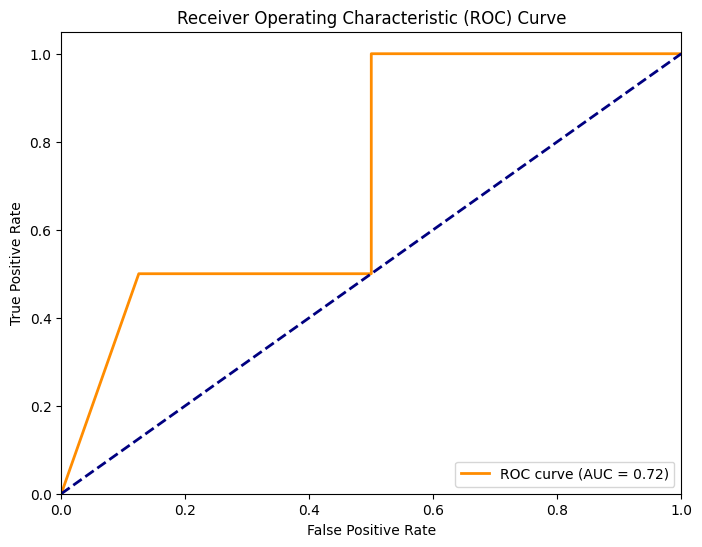

In [78]:
# Plot AUC curve in entirety
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [79]:
# Label the confusion matrix
# Pretty print the confusion matrix
class_names = ['Non-Interview', 'Interview']
print('Confusion Matrix')
print('-'*20)
print(f'{"":>10}{"Predicted Non-Interview":>15}{"Predicted Interview":>15}')
print(f'{"Actual Non-Interview":>10}{cm[0,0]:>15}{cm[0,1]:>15}')
print(f'{"Actual Interview":>10}{cm[1,0]:>15}{cm[1,1]:>15}')
print('-'*20)

Confusion Matrix
--------------------
          Predicted Non-InterviewPredicted Interview
Actual Non-Interview              2              6
Actual Interview              0              2
--------------------


# Actual Test Data

In [80]:
# Get test data
person_name = 'jeff bezos'
df = search_videos_advanced(person_name, 200, 50, 'long')
df.head(5)

,PublishedAt,ChannelId,Title,Description,Thumbnails,ChannelTitle,LiveBroadcastContent,PublishTime,VideoID,URL,Duration,ViewCount,LikeCount,DislikeCount,CommentCount
33,2024-03-24T15:10:00Z,UCEm_0Cv-bdGNSDiG55QJ0Yw,SCP-5821 Jeff Bezos Tastes Amazing! (Compilation),Join the DR BOB SQUAD by going to https://www....,https://i.ytimg.com/vi/KAk-6ayGlTs/default.jpg,Dr Bob,none,None,KAk-6ayGlTs,https://www.youtube.com/watch?v=KAk-6ayGlTs,232.73,66654,1021,0,84
12,2021-08-20T17:51:30Z,UC6LEH0rS9V0BF5aNhVYdykQ,Bo Burnham vs. Jeff Bezos,COVID make man sad\n\nPatreon: https://www.pat...,https://i.ytimg.com/vi/UvYcunuF3Eo/default.jpg,CJ The X,none,None,UvYcunuF3Eo,https://www.youtube.com/watch?v=UvYcunuF3Eo,146.25,1459518,84849,0,8141
37,2023-01-26T19:45:00Z,UCznv7Vf9nBdJYvBagFdAHWw,Legendary Investor Bill Gurley on Investing Ru...,Brought to you by Protekt’s REST sleep supplem...,https://i.ytimg.com/vi/HSVFZ2Qbv3I/default.jpg,Tim Ferriss,none,None,HSVFZ2Qbv3I,https://www.youtube.com/watch?v=HSVFZ2Qbv3I,132.90,82738,1568,0,64
9,2023-12-14T17:53:21Z,UCSHZKyawb77ixDdsGog4iWA,Jeff Bezos: Amazon and Blue Origin | Lex Fridm...,Jeff Bezos is the founder of Amazon and Blue O...,https://i.ytimg.com/vi/DcWqzZ3I2cY/default.jpg,Lex Fridman,none,None,DcWqzZ3I2cY,https://www.youtube.com/watch?v=DcWqzZ3I2cY,131.53,4229458,94985,0,10428
28,2024-02-16T14:00:11Z,UCKmkpoEqg1sOMGEiIysP8Tw,Jeff Bezos' Advice if you're dreaming of success,✎ Get free access to our vault of PDF summarie...,https://i.ytimg.com/vi/Jx2Kzkj1iQE/default.jpg,Evan Carmichael,none,None,Jx2Kzkj1iQE,https://www.youtube.com/watch?v=Jx2Kzkj1iQE,115.48,6269,252,0,57


In [81]:
X_test_real = df['Description']
# Change text into numerical format
X_test_numerical_format = [get_text_features(text) for text in X_test_real]

In [82]:
# # Predict on test data
# predictions = model.predict_proba(X_test_numerical_format)[:, 1]
# print(predictions)

# df['predictions'] = predictions
# df = df.sort_values('predictions', ascending=False)
# df.head(5)
# df.to_csv(f'{person_name}.csv', index=False)

# Use DistilBERT for Faster but Big Guns

In [85]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_features(text):
    if len(text) >= 512:
        print("Text length is longer than 512: " + str(len(text)))
    input_ids = torch.tensor([tokenizer.encode(text[:512], add_special_tokens=True)])
    attention_mask = torch.ones_like(input_ids)
    return input_ids, attention_mask

In [90]:
X_numerical = [get_bert_features(text) for text in X]
print(X_numerical)

Text length is longer than 512: 1557
Text length is longer than 512: 1698
Text length is longer than 512: 2075
Text length is longer than 512: 1658
Text length is longer than 512: 784
Text length is longer than 512: 591
Text length is longer than 512: 2085
Text length is longer than 512: 748
Text length is longer than 512: 2443
Text length is longer than 512: 3082
Text length is longer than 512: 2636
Text length is longer than 512: 1270
Text length is longer than 512: 1434
Text length is longer than 512: 2237
Text length is longer than 512: 749
Text length is longer than 512: 1557
Text length is longer than 512: 2167
Text length is longer than 512: 1200
Text length is longer than 512: 1741
Text length is longer than 512: 624
Text length is longer than 512: 1781
Text length is longer than 512: 1545
Text length is longer than 512: 788
Text length is longer than 512: 769
Text length is longer than 512: 1066
Text length is longer than 512: 993
Text length is longer than 512: 615
Text lengt

In [91]:
# Bert only has predicted class:
output = model(X_numerical)
print(output)
predictions = output[0]
print(predictions)

df['predictions'] = predictions
df = df.sort_values('predictions', ascending=False)
df.head(5)
df.to_csv(f'{person_name}.csv', index=False)

TypeError: list indices must be integers or slices, not tuple